# CYBERML – Analyse du CIC IoT-DIAD 2024

Ce notebook conçoit et évalue une chaîne de traitement batch pour **(i)** la détection d’anomalies (non supervisée) et **(ii)** la classification d’attaques (supervisée), à partir de caractéristiques de flux réseau (flow-based).


## 1. Introduction

Objectif : construire un pipeline reproductible pour des données de flux en cybersécurité, comparer **3 algorithmes non supervisés** et **3 algorithmes supervisés**, et rapporter les métriques requises :
- Matrice de confusion, Précision, Rappel, AUPRC, Balanced accuracy, MCC.

On commence en binaire (**Benign vs Attack**) puis on augmente progressivement la diversité des attaques.


## 2. Jeu de données et protocole expérimental

Jeu de données : **CIC IoT-DIAD 2024 – Anomaly Detection (Flow Based Features)**.

Dans cette version du notebook, on utilise **toutes les attaques** disponibles (dans la limite de budgets RAM-safe) :
- Benign
- BruteForce
- DDoS
- DoS
- Mirai
- Recon
- Spoofing
- Web-Based

Point critique : le split train/test est fait **par fichier (group split)** pour éviter la fuite de données (flows très similaires d’un même PCAP en train et en test).


In [2]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    average_precision_score,
    balanced_accuracy_score,
    matthews_corrcoef,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

VERBOSE = False
BASE_DIR = "./Anomaly Detection - Flow Based Features"
TARGET_FAMILIES = ["Benign", "BruteForce", "DDoS", "DoS", "Mirai", "Recon", "Spoofing", "Web-Based"]
DROP_PATTERNS = ["ip", "port", "time", "timestamp", "flow id", "src", "dst"]
DROP_CANDIDATES = {
    "Flow ID",
    "Src IP",
    "Dst IP",
    "Source IP",
    "Destination IP",
    "Src Port",
    "Dst Port",
    "Source Port",
    "Destination Port",
    "Timestamp",
    "StartTime",
    "Start Time",
    "Flow Start",
    "Flow Start Time",
    "Unnamed: 0",
}
CANONICAL_FAMILY = {
    "benign": "Benign",
    "ddos": "DDoS",
    "dos": "DoS",
    "mirai": "Mirai",
    "recon": "Recon",
    "spoofing": "Spoofing",
    "webbased": "Web-Based",
    "bruteforce": "BruteForce",
}

LIGHT_MODE = True

MAX_ROWS_PER_FILE = 10_000 if LIGHT_MODE else 50_000_000
MAX_ROWS_PER_FAMILY = 60_000 if LIGHT_MODE else 200_000_000
MAX_ROWS_TOTAL = 300_000 if LIGHT_MODE else 800_000

MIN_SAMPLES_PER_SUBTYPE = 3000 if not LIGHT_MODE else 15_000
TOP_K_SUBTYPES = 20 if not LIGHT_MODE else 10
MAX_ROWS_PER_SUBTYPE = 20_000 if not LIGHT_MODE else 10_000

In [4]:
def should_drop(col: str) -> bool:
    name = col.strip()
    if name in DROP_CANDIDATES:
        return True
    low = name.lower()
    if any(p in low for p in DROP_PATTERNS) and low not in ["fwd", "bwd"]:
        return True
    return False

def infer_family_subtype(csv_path: str, flow_root: str):
    rel = os.path.relpath(csv_path, flow_root)
    parts = rel.split(os.sep)
    key = "".join(ch for ch in parts[0].lower() if ch.isalnum())
    family = CANONICAL_FAMILY.get(key, parts[0])
    subtype = parts[1] if len(parts) >= 3 else family
    return family, subtype


def list_all_flow_csvs(flow_root: str):
    paths = []
    for root, _, files in os.walk(flow_root):
        for f in files:
            if f.endswith(".csv"):
                paths.append(os.path.join(root, f))
    return sorted(paths)


def load_all_flows_ram_safe(
    flow_root: str,
    target_families: list[str],
    feature_cols: list[str],
    max_rows_per_file: int,
    max_rows_per_family: int,
    max_rows_total: int,
    chunksize: int = 200_000,
):
    by_family: dict[str, list[str]] = {f: [] for f in target_families}
    for p in list_all_flow_csvs(flow_root):
        fam, _ = infer_family_subtype(p, flow_root)
        if fam in by_family:
            by_family[fam].append(p)
    frames = []
    loaded_total = 0
    loaded_by_family = {f: 0 for f in target_families}
    cursors = {f: 0 for f in target_families}
    while loaded_total < max_rows_total:
        progressed = False
        for fam in target_families:
            if loaded_total >= max_rows_total:
                break
            if max_rows_per_family - loaded_by_family[fam] <= 0 or  max_rows_total - loaded_total <= 0:
                continue
            paths = by_family.get(fam, [])
            cur = cursors[fam]
            if cur >= len(paths):
                continue
            p = paths[cur]
            cursors[fam] = cur + 1
            fam2, sub = infer_family_subtype(p, flow_root)
            group = os.path.relpath(p, flow_root)
            usecols = [c for c in feature_cols if c in set(pd.read_csv(p, nrows=0).columns)]
            if not usecols:
                continue
            chunks = []
            kept = 0
            for chunk in pd.read_csv(p, usecols=usecols, chunksize=chunksize, low_memory=True):
                for c in chunk.columns:
                    chunk[c] = pd.to_numeric(chunk[c], errors="coerce")
                chunk = chunk.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
                chunk = chunk.astype(np.float32)
                remaining = min(max_rows_per_file, max_rows_per_family - loaded_by_family[fam],  max_rows_total - loaded_total) - kept
                if remaining <= 0:
                    break
                if len(chunk) > remaining:
                    chunk = chunk.sample(n=remaining, random_state=RANDOM_STATE)
                kept += len(chunk)

                chunk["attack_family"] = fam2
                chunk["attack_subtype"] = sub
                chunk["group"] = group
                chunks.append(chunk)
                if kept >= min(max_rows_per_file, max_rows_per_family - loaded_by_family[fam],  max_rows_total - loaded_total):
                    break
            if not chunks:
                continue
            dfp = pd.concat(chunks, ignore_index=True)
            for c in [c for c in feature_cols if c not in dfp.columns]:
                dfp[c] = np.nan
            if len(dfp) == 0:
                continue
            frames.append(dfp)
            loaded_total += len(dfp)
            loaded_by_family[fam2] += len(dfp)
            progressed = True
        if not progressed:
            break
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(), loaded_by_family


def group_split_indices(y, groups, test_size=0.2, random_state=RANDOM_STATE, require_all_classes_train=False):
    classes = set(np.unique(y))
    gss = GroupShuffleSplit(n_splits=300, test_size=test_size, random_state=random_state)
    for tr, te in gss.split(np.zeros_like(y), y, groups=groups):
        y_tr = set(y[tr])
        y_te = set(y[te])
        if require_all_classes_train and y_tr != classes:
            continue
        if len(y_te) == 0:
            continue
        if len(classes) == 2 and len(y_te) < 2:
            continue
        return tr, te
    raise RuntimeError(
        "Impossible de trouver un split par fichier satisfaisant (classes manquantes). "
        "Essaie de réduire test_size ou d'augmenter les budgets."
    )


def eval_binary(y_true, y_pred, y_score=None, title="model", verbose=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    if y_score is None:
        y_score = y_pred.astype(float)
    auprc = average_precision_score(y_true, y_score)

    if verbose is None:
        verbose = bool(globals().get("VERBOSE", False))
    if verbose:
        print()
        print(f"=== {title} ===")
        print("Confusion matrix:")
        print(cm)
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"AUPRC:     {auprc:.4f}")
        print(f"Balanced Acc: {bal_acc:.4f}")
        print(f"MCC:       {mcc:.4f}")

    return {
        "title": title,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
        "precision": float(prec),
        "recall": float(rec),
        "auprc": float(auprc),
        "balanced_acc": float(bal_acc),
        "mcc": float(mcc),
    }


def plot_confusion(y_true, y_pred_or_score, title, threshold=0.5):
    y_arr = np.asarray(y_pred_or_score)
    if y_arr.dtype.kind in "fc" and y_arr.ndim == 1:
        y_pred = (y_arr >= threshold).astype(int)
    else:
        y_pred = y_pred_or_score

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Benign", "Attaque"],
        yticklabels=["Benign", "Attaque"],
    )
    plt.title(title)
    plt.ylabel("Réel")
    plt.xlabel("Prédit")
    plt.show()



def eval_multiclass(y_true, y_pred, y_proba=None, classes=None, title="model", verbose=None):
    if classes is None:
        classes = np.unique(y_true)

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_w = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    auprc_macro = None
    if y_proba is not None:
        Y = label_binarize(y_true, classes=classes)
        present = Y.sum(axis=0) > 0
        if present.any():
            auprc_macro = average_precision_score(Y[:, present], y_proba[:, present], average="macro")

    if verbose is None:
        verbose = bool(globals().get("VERBOSE", False))
    if verbose:
        print()
        print(f"=== {title} ===")
        print("Confusion matrix:")
        print(cm)
        print(f"Precision macro:  {prec_macro:.4f} | weighted: {prec_w:.4f}")
        print(f"Recall macro:     {rec_macro:.4f} | weighted: {rec_w:.4f}")
        if auprc_macro is not None:
            print(f"AUPRC macro (OvR): {auprc_macro:.4f}")
        print(f"Balanced Acc:     {bal_acc:.4f}")
        print(f"MCC:              {mcc:.4f}")

    return {
        "title": title,
        "cm": cm,
        "prec_macro": float(prec_macro),
        "rec_macro": float(rec_macro),
        "prec_weighted": float(prec_w),
        "rec_weighted": float(rec_w),
        "auprc_macro_ovr": None if auprc_macro is None else float(auprc_macro),
        "balanced_acc": float(bal_acc),
        "mcc": float(mcc),
    }


def plot_confusion_multiclass(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel("Réel")
    plt.xlabel("Prédit")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [5]:
def prepare_binary_scenario(df_all: pd.DataFrame, feature_cols: list[str], name: str = "Binaire"):
    X_raw = df_all[feature_cols].to_numpy()
    y = (df_all["attack_family"] != "Benign").astype(np.int8).to_numpy()
    groups = df_all["group"].to_numpy()

    train_idx, test_idx = group_split_indices(y, groups, test_size=0.2, random_state=RANDOM_STATE, require_all_classes_train=True)

    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    return {
        "name": name,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "scaler": scaler,
        "feature_names": feature_cols,
        "X_raw": X_raw,
        "y": y,
        "groups": groups,
        "X_train": X_train_s,
        "X_test": X_test_s,
        "y_train": y_train,
        "y_test": y_test,
    }

def prepare_st_scenario(df_all: pd.DataFrame, feature_cols: list[str], name: str = "Sous-types"):
    df_st = df_all.copy()
    if "attack_family" in df_st.columns and "attack_subtype" in df_st.columns:
        df_st.loc[df_st["attack_family"] == "Benign", "attack_subtype"] = "Benign"
    sub_counts = df_st["attack_subtype"].value_counts()
    kept = sub_counts[sub_counts >= MIN_SAMPLES_PER_SUBTYPE]
    if TOP_K_SUBTYPES is not None and len(kept) > TOP_K_SUBTYPES:
        kept = kept.head(TOP_K_SUBTYPES)
    kept_subtypes = set(kept.index)
    df_st["subtype_filtered"] = df_st["attack_subtype"].where(
        df_st["attack_subtype"].isin(kept_subtypes), other="Other"
    )
    parts = []
    for st, g in df_st.groupby("subtype_filtered", sort=False):
        if len(g) > MAX_ROWS_PER_SUBTYPE:
            g = g.sample(n=MAX_ROWS_PER_SUBTYPE, random_state=RANDOM_STATE)
        parts.append(g)

    df_st = pd.concat(parts, ignore_index=True)

    subtypes = sorted(df_st["subtype_filtered"].astype(str).unique())
    subtype_to_id = {s: i for i, s in enumerate(subtypes)}
    id_to_subtype = {i: s for s, i in subtype_to_id.items()}

    X_raw = df_st[feature_cols].to_numpy()
    y = df_st["subtype_filtered"].map(subtype_to_id).astype(np.int16).to_numpy()
    groups = df_st["group"].to_numpy()

    train_idx, test_idx = group_split_indices(
        y,
        groups,
        test_size=0.2,
        random_state=RANDOM_STATE,
        require_all_classes_train=True,
    )

    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    return {
        "name": name,
        "classes": subtypes,
        "subtype_to_id": subtype_to_id,
        "id_to_subtype": id_to_subtype,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "scaler": scaler,
        "feature_names": feature_cols,
        "X_raw": X_raw,
        "y": y,
        "groups": groups,
        "X_train": X_train_s,
        "X_test": X_test_s,
        "y_train": y_train,
        "y_test": y_test,
    }

def prepare_fam_scenario(df_all: pd.DataFrame, feature_cols: list[str], name: str = "Familles"):
    X_raw = df_all[feature_cols].to_numpy()
    families = sorted(df_all["attack_family"].astype(str).unique())
    family_to_id = {f: i for i, f in enumerate(families)}
    id_to_family = {i: f for f, i in family_to_id.items()}

    y = df_all["attack_family"].map(family_to_id).astype(np.int16).to_numpy()
    groups = df_all["group"].to_numpy()

    train_idx, test_idx = group_split_indices(
        y,
        groups,
        test_size=0.2,
        random_state=RANDOM_STATE,
        require_all_classes_train=True,
    )

    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    return {
        "name": name,
        "classes": families,
        "family_to_id": family_to_id,
        "id_to_family": id_to_family,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "scaler": scaler,
        "feature_names": feature_cols,
        "X_raw": X_raw,
        "y": y,
        "groups": groups,
        "X_train": X_train_s,
        "X_test": X_test_s,
        "y_train": y_train,
        "y_test": y_test,
    }


all_csvs = list_all_flow_csvs(BASE_DIR)
target_csvs = [p for p in all_csvs if infer_family_subtype(p, BASE_DIR)[0] in TARGET_FAMILIES]
all_cols = list(pd.read_csv(target_csvs[0], nrows=0).columns) 
drop_cols = [c for c in all_cols if should_drop(c)]
label_cols = [c for c in all_cols if c.lower() in ["label", "class", "category", "attack", "target"]]
feature_cols_common = [c for c in all_cols if (c not in drop_cols) and (c not in label_cols)]

df_all, loaded_by_family = load_all_flows_ram_safe(
    flow_root=BASE_DIR,
    target_families=TARGET_FAMILIES,
    feature_cols=feature_cols_common,
    max_rows_per_file=MAX_ROWS_PER_FILE,
    max_rows_per_family=MAX_ROWS_PER_FAMILY,
    max_rows_total=MAX_ROWS_TOTAL,
    chunksize=200_000,
)

binary_scenario = prepare_binary_scenario(df_all, feature_cols_common, name="Binaire")
pd.Series(np.unique(binary_scenario["groups"][binary_scenario["train_idx"]])).to_csv("train_groups_binary.csv", index=False, header=False)
pd.Series(np.unique(binary_scenario["groups"][binary_scenario["test_idx"]])).to_csv("test_groups_binary.csv", index=False, header=False)

family_scenario = prepare_fam_scenario(df_all, feature_cols_common, name="Familles")
pd.Series(np.unique(family_scenario["groups"][family_scenario["train_idx"]])).to_csv("train_groups_fam.csv", index=False, header=False)
pd.Series(np.unique(family_scenario["groups"][family_scenario["test_idx"]])).to_csv("test_groups_fam.csv", index=False, header=False)

st_scenario = prepare_st_scenario(df_all, feature_cols_common, name="Sous-types")
pd.Series(np.unique(st_scenario["groups"][st_scenario["train_idx"]])).to_csv("train_groups_st.csv", index=False, header=False)
pd.Series(np.unique(st_scenario["groups"][st_scenario["test_idx"]])).to_csv("test_groups_st.csv", index=False, header=False)


## 5. Expériences de détection d’anomalies

Les modèles non supervisés sont entraînés **uniquement sur le trafic Benign** puis évalués sur l’ensemble du test.
On rapporte les métriques et on trace une matrice de confusion (Figure 4).


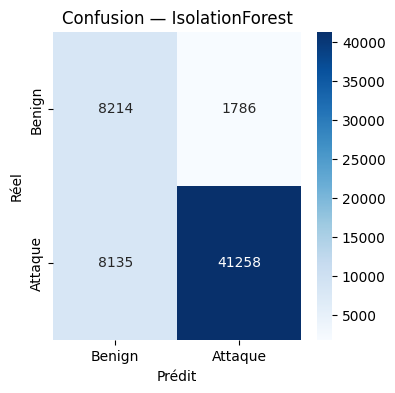

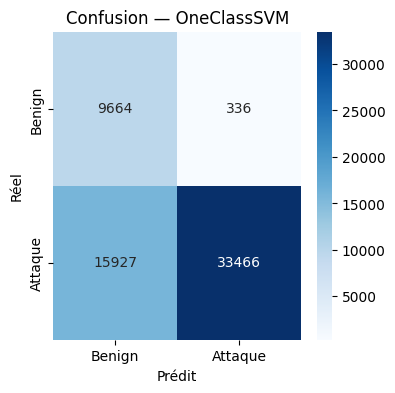

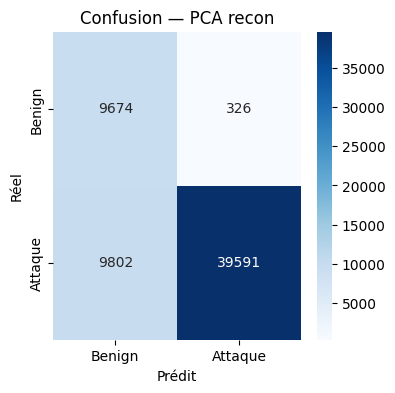

,scenario,title,precision,recall,auprc,balanced_acc,mcc,tn,fp,fn,tp
0,Binaire,Non supervisé - IsolationForest,0.958508,0.835301,0.967265,0.828350,0.550172,8214,1786,8135,41258
1,Binaire,Non supervisé - OneClassSVM,0.990060,0.677545,0.970186,0.821973,0.486594,9664,336,15927,33466
2,Binaire,Non supervisé - Erreur de reconstruction PCA,0.991833,0.801551,0.973635,0.884475,0.612918,9674,326,9802,39591


In [6]:
results = []
artifacts = {}


contam = float(np.clip(float(np.mean(binary_scenario["y_train"])), 0.01, 0.30))
iso = IsolationForest(n_estimators=300, contamination=contam, random_state=RANDOM_STATE, n_jobs=-1)
iso.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
iso_pred = (iso.predict(binary_scenario["X_test"]) == -1).astype(int)
iso_score = -iso.score_samples(binary_scenario["X_test"])


oc = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
oc.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
oc_pred = (oc.predict(binary_scenario["X_test"]) == -1).astype(int)
oc_score = -oc.decision_function(binary_scenario["X_test"])


pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
pca.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
recon_error = np.mean((binary_scenario["X_test"] - pca.inverse_transform(pca.transform(binary_scenario["X_test"]))) ** 2, axis=1)
train_recon_error = np.mean((binary_scenario["X_train"][binary_scenario["y_train"] == 0] - pca.inverse_transform(pca.transform(binary_scenario["X_train"][binary_scenario["y_train"] == 0]))) ** 2, axis=1)
pca_pred = (recon_error > np.quantile(train_recon_error, 0.95)).astype(int)





results.append(eval_binary(binary_scenario["y_test"], iso_pred, y_score=iso_score, title=f"Non supervisé - IsolationForest"))
results.append(eval_binary(binary_scenario["y_test"], oc_pred, y_score=oc_score, title=f"Non supervisé - OneClassSVM"))
results.append(eval_binary(binary_scenario["y_test"], pca_pred, y_score=recon_error, title=f"Non supervisé - Erreur de reconstruction PCA"))
for r in results:
	r["scenario"] = binary_scenario["name"]

artifacts["iso_pred"] = iso_pred
artifacts["oc_pred"] = oc_pred
artifacts["pca_pred"] = pca_pred

plot_confusion(binary_scenario["y_test"], artifacts["iso_pred"],   "Confusion — IsolationForest")
plot_confusion(binary_scenario["y_test"], artifacts["oc_pred"],    "Confusion — OneClassSVM")
plot_confusion(binary_scenario["y_test"], artifacts["pca_pred"],   "Confusion — PCA recon")

unsup_df = pd.DataFrame(results)
unsup_df = unsup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc", "tn", "fp", "fn", "tp"]]
unsup_df

## 6. Expériences de classification supervisée

Les modèles supervisés sont entraînés sur des données labellisées **Benign vs Attack** (toutes attaques chargées dans `df_all`).

Le split est fait **par fichier** (GroupShuffleSplit) pour éviter la fuite.
On trace les matrices de confusion (Figure 4) et les courbes précision–rappel (Figure 5).


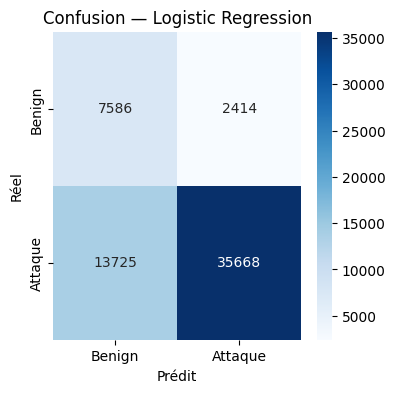

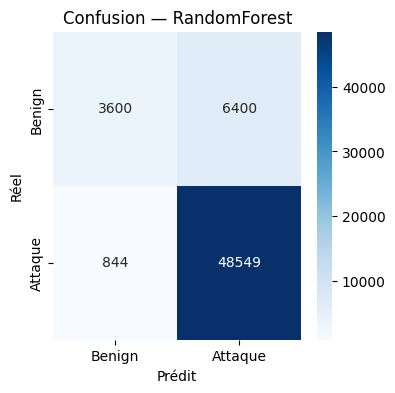

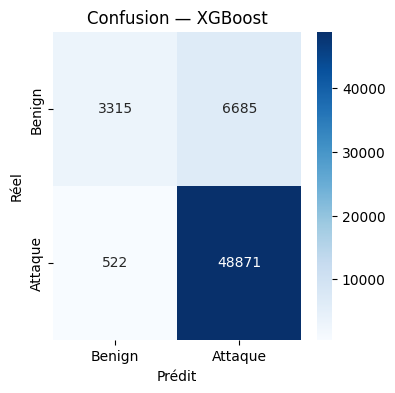

,scenario,title,precision,recall,auprc,balanced_acc,mcc,tn,fp,fn,tp
0,Binaire,Supervisé - Régression logistique,0.936610,0.722127,0.959541,0.740363,0.375033,7586,2414,13725,35668
1,Binaire,Supervisé - Forêt aléatoire,0.883528,0.982913,0.929537,0.671456,0.487696,3600,6400,844,48549
2,Binaire,Supervisé - XGBoost (CPU hist),0.879671,0.989432,0.982415,0.660466,0.488522,3315,6685,522,48871


In [7]:
results = []
artifacts = {}

lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(binary_scenario["X_train"], binary_scenario["y_train"])
lr_pred = lr.predict(binary_scenario["X_test"])
lr_score = lr.predict_proba(binary_scenario["X_test"])[:, 1]


rf = RandomForestClassifier(n_estimators=400,random_state=RANDOM_STATE,n_jobs=-1,class_weight="balanced_subsample")
rf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
rf_pred = rf.predict(binary_scenario["X_test"])
rf_score = rf.predict_proba(binary_scenario["X_test"])[:, 1]


xgb_clf = xgb.XGBClassifier(
	n_estimators=600,
	max_depth=8,
	learning_rate=0.05,
	subsample=0.8,
	colsample_bytree=0.8,
	reg_lambda=1.0,
	min_child_weight=1,
	tree_method="hist",
	eval_metric="logloss",
	random_state=RANDOM_STATE,
	n_jobs=-1,
)
xgb_clf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
xgb_score = xgb_clf.predict_proba(binary_scenario["X_test"])[:, 1]
xgb_pred = (xgb_score >= 0.5).astype(int)



results.append(eval_binary(binary_scenario["y_test"], lr_pred, y_score=lr_score, title=f"Supervisé - Régression logistique"))
results.append(eval_binary(binary_scenario["y_test"], rf_pred, y_score=rf_score, title=f"Supervisé - Forêt aléatoire"))
results.append(eval_binary(binary_scenario["y_test"], xgb_pred, y_score=xgb_score, title=f"Supervisé - XGBoost (CPU hist)"))

artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred
artifacts["xgb_model"] = xgb_clf

for r in results:
	r["scenario"] = binary_scenario["name"]

plot_confusion(binary_scenario["y_test"], artifacts["lr_pred"], "Confusion — Logistic Regression")
plot_confusion(binary_scenario["y_test"], artifacts["rf_pred"], "Confusion — RandomForest",)
plot_confusion(binary_scenario["y_test"], artifacts["xgb_pred"], "Confusion — XGBoost",)

sup_df = pd.DataFrame(results)
sup_df = sup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc", "tn", "fp", "fn", "tp"]]
sup_df

In [8]:
binary_table = pd.concat([unsup_df, sup_df], ignore_index=True)

binary_table = binary_table[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

binary_table

,title,precision,recall,auprc,balanced_acc,mcc
0,Non supervisé - IsolationForest,0.958508,0.835301,0.967265,0.828350,0.550172
1,Non supervisé - OneClassSVM,0.990060,0.677545,0.970186,0.821973,0.486594
2,Non supervisé - Erreur de reconstruction PCA,0.991833,0.801551,0.973635,0.884475,0.612918
3,Supervisé - Régression logistique,0.936610,0.722127,0.959541,0.740363,0.375033
4,Supervisé - Forêt aléatoire,0.883528,0.982913,0.929537,0.671456,0.487696
5,Supervisé - XGBoost (CPU hist),0.879671,0.989432,0.982415,0.660466,0.488522


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, matthews_corrcoef

Xtr = binary_scenario["X_train"].astype(np.float32, copy=False)
ytr = binary_scenario["y_train"].astype(np.int64, copy=False)
Xte_full = binary_scenario["X_test"].astype(np.float32, copy=False)
yte_full = binary_scenario["y_test"].astype(np.int64, copy=False)

ADV_MAX_TEST = 2000
if Xte_full.shape[0] > ADV_MAX_TEST:
    idx = np.random.RandomState(RANDOM_STATE).choice(Xte_full.shape[0], ADV_MAX_TEST, replace=False)
    Xte = Xte_full[idx]
    yte = yte_full[idx]
else:
    Xte, yte = Xte_full, yte_full

lr_adv = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
lr_adv.fit(Xtr, ytr)

xgb_model = artifacts["xgb_model"]
CLIP_MIN, CLIP_MAX = -5.0, 5.0
w = lr_adv.coef_.astype(np.float32).ravel()
b = float(lr_adv.intercept_[0])
sign_w = np.sign(w).astype(np.float32)


def sigmoid(z):
    z = np.clip(z, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-z))

def lr_score(lr_unused, X):
    z = X @ w + b
    return sigmoid(z)

def fgsm_lr(lr_unused, X, y, eps, clip_min=-5.0, clip_max=5.0):
    if eps == 0.0:
        return X
    p = lr_score(None, X).astype(np.float32)
    y = y.astype(np.float32)
    s = np.where((p - y) >= 0.0, 1.0, -1.0).astype(np.float32)
    X_adv = X + (eps * s)[:, None] * sign_w[None, :]
    return np.clip(X_adv, clip_min, clip_max).astype(np.float32, copy=False)

def eval_scores(y_true, y_score):
    y_pred = (y_score >= 0.5).astype(int)
    auprc = average_precision_score(y_true, y_score)
    mcc = matthews_corrcoef(y_true, y_pred)
    return float(auprc), float(mcc)


def xgb_score(model, X):
    return model.predict_proba(X)[:, 1]

eps_list = [0.0, 0.1, 0.5, 1.0]
rows = []
for eps in eps_list:
    X_adv = fgsm_lr(lr_adv, Xte, yte, eps, CLIP_MIN, CLIP_MAX)
    p_lr = lr_score(lr_adv, X_adv)
    a_lr, m_lr = eval_scores(yte, p_lr)
    p_x = xgb_score(xgb_model, X_adv)
    a_x, m_x = eval_scores(yte, p_x)
    rows.append((eps, a_lr, m_lr, a_x, m_x))
adv_table = pd.DataFrame(rows, columns=["eps", "AUPRC_LR", "MCC_LR", "AUPRC_XGB(transfer)", "MCC_XGB(transfer)"])
adv_table

,eps,AUPRC_LR,MCC_LR,AUPRC_XGB(transfer),MCC_XGB(transfer)
0,0.0,0.954445,0.359388,0.980020,0.508923
1,0.1,0.639771,-0.659372,0.817223,0.000000
2,0.5,0.623868,-0.988301,0.628946,0.000000
3,1.0,0.771528,-0.988301,0.629170,0.000000


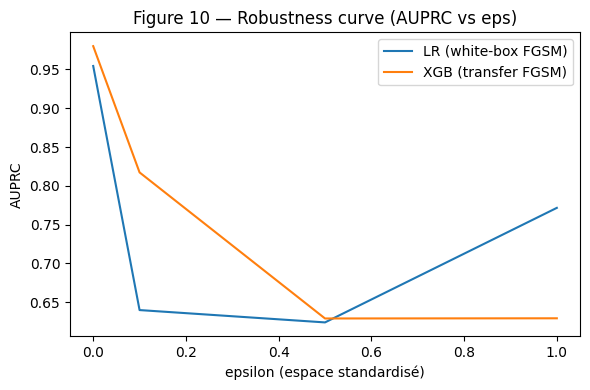

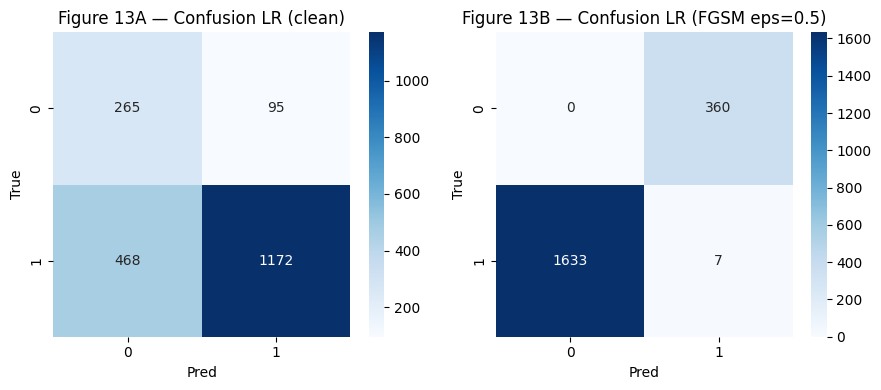

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 4))
plt.plot(adv_table["eps"], adv_table["AUPRC_LR"], label="LR (white-box FGSM)")
plt.plot(adv_table["eps"], adv_table["AUPRC_XGB(transfer)"], label="XGB (transfer FGSM)")
plt.xlabel("epsilon (espace standardisé)")
plt.ylabel("AUPRC")
plt.title("Figure 10 — Robustness curve (AUPRC vs eps)")
plt.legend()
plt.tight_layout()
plt.show()

EPS_SHOW = 0.5
X_adv = fgsm_lr(lr_adv, Xte, yte, EPS_SHOW, CLIP_MIN, CLIP_MAX)
p_clean = lr_score(lr_adv, Xte)
p_adv = lr_score(lr_adv, X_adv)
yhat_clean = (p_clean >= 0.5).astype(int)
yhat_adv = (p_adv >= 0.5).astype(int)
cm_clean = confusion_matrix(yte, yhat_clean)
cm_adv = confusion_matrix(yte, yhat_adv)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_clean, annot=True, fmt="d", cmap="Blues")
plt.title("Figure 13A — Confusion LR (clean)")
plt.xlabel("Pred")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(cm_adv, annot=True, fmt="d", cmap="Blues")
plt.title(f"Figure 13B — Confusion LR (FGSM eps={EPS_SHOW})")
plt.xlabel("Pred")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## 6A. Partie 2A — Classification multi-classes (familles)

Objectif : passer de **Benign vs Attack** à un suivi *par familles d’attaques* (≈ 8 classes) pour répondre à l’idée de *tracking attacks*.

Point critique (très important) : éviter la fuite de données. Un split aléatoire par lignes mélange des flows très proches issus d’un même PCAP entre train/test → métriques artificiellement gonflées.



In [ ]:
fam_results = []
artifacts = {}



lr = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(family_scenario["X_train"], family_scenario["y_train"])
lr_pred = lr.predict(family_scenario["X_test"])
lr_proba = lr.predict_proba(family_scenario["X_test"])


rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced_subsample")
rf.fit(family_scenario["X_train"], family_scenario["y_train"])
rf_pred = rf.predict(family_scenario["X_test"])
rf_proba = rf.predict_proba(family_scenario["X_test"])


xgb_clf = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(family_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_clf.fit(family_scenario["X_train"], family_scenario["y_train"])
xgb_proba = xgb_clf.predict_proba(family_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)




artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

fam_results.append(eval_multiclass(family_scenario["y_test"], lr_pred, y_proba=lr_proba, classes=lr.classes_, title="Multiclass - LogisticRegression"))
fam_results.append(eval_multiclass(family_scenario["y_test"], rf_pred, y_proba=rf_proba, classes=rf.classes_, title="Multiclass - RandomForest"))
fam_results.append(eval_multiclass(family_scenario["y_test"], xgb_pred, y_proba=xgb_proba, classes=np.arange(len(family_scenario["classes"])), title="Multiclass - XGBoost (hist)"))
for r in fam_results:
    r["scenario"] = family_scenario["name"]

plot_confusion_multiclass(family_scenario["y_test"], artifacts["lr_pred"], labels=family_scenario["classes"], title="Figure 6 — Matrice de confusion (LogReg, familles)")
plot_confusion_multiclass(family_scenario["y_test"], artifacts["rf_pred"], labels=family_scenario["classes"], title="Figure 7 — Matrice de confusion (RF, familles)")
plot_confusion_multiclass(family_scenario["y_test"], artifacts["xgb_pred"], labels=family_scenario["classes"], title="Figure 8 — Matrice de confusion (XGB, familles)")

fam_df = pd.DataFrame(fam_results)
fam_df = fam_df[["scenario", "title", "prec_macro", "rec_macro", "prec_weighted", "rec_weighted", "auprc_macro_ovr", "balanced_acc", "mcc"]]
fam_df


## 6B. Partie 2B — Classification multi-classes (sous-types)

Objectif : affiner le suivi d’attaques en passant des familles (≈ 8 classes) aux **sous-types** (`attack_subtype`).

Défis principaux :
- Les sous-types sont plus nombreux et souvent **très déséquilibrés**.
- Split **par fichier** obligatoire (anti-fuite).
- Éviter des classes absentes du train/test : on **filtre/regroupe** les sous-types trop rares.


In [ ]:
st_results = []
artifacts = {}



lr_st = LogisticRegression(max_iter=4000,class_weight="balanced",solver="saga",random_state=RANDOM_STATE)
lr_st.fit(st_scenario["X_train"], st_scenario["y_train"])
lr_pred = lr_st.predict(st_scenario["X_test"])
lr_proba = lr_st.predict_proba(st_scenario["X_test"])


rf_st = RandomForestClassifier(n_estimators=150,n_jobs=-1,random_state=RANDOM_STATE,class_weight="balanced_subsample")
rf_st.fit(st_scenario["X_train"], st_scenario["y_train"])
rf_pred = rf_st.predict(st_scenario["X_test"])
rf_proba = rf_st.predict_proba(st_scenario["X_test"])


xgb_st = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(st_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_st.fit(st_scenario["X_train"], st_scenario["y_train"])
xgb_proba = xgb_st.predict_proba(st_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)



artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

st_results.append(eval_multiclass(st_scenario["y_test"], lr_pred, y_proba=lr_proba, classes=lr_st.classes_, title="Subtype - LogisticRegression"))
st_results.append(eval_multiclass(st_scenario["y_test"], rf_pred, y_proba=rf_proba, classes=rf_st.classes_, title="Subtype - RandomForest"))
st_results.append(eval_multiclass(st_scenario["y_test"], xgb_pred, y_proba=xgb_proba, classes=np.arange(len(st_scenario["classes"])), title="Subtype - XGBoost (hist)"))
for r in st_results:
    r["scenario"] = st_scenario["name"]

plot_confusion_multiclass(st_scenario["y_test"], artifacts["lr_pred"], labels=st_scenario["classes"], title="Figure 9 — Confusion (LogReg, sous-types)")
plot_confusion_multiclass(st_scenario["y_test"], artifacts["rf_pred"], labels=st_scenario["classes"], title="Figure 10 — Confusion (RF, sous-types)")
plot_confusion_multiclass(st_scenario["y_test"], artifacts["xgb_pred"], labels=st_scenario["classes"], title="Figure 11 — Confusion (XGB, sous-types)")

st_df = pd.DataFrame(st_results)
st_df = st_df[["scenario", "title", "prec_macro", "rec_macro", "prec_weighted", "rec_weighted", "auprc_macro_ovr", "balanced_acc", "mcc"]]
st_df


In [ ]:
fam_table = pd.DataFrame(fam_results)[[
    "title",
    "prec_macro",
    "rec_macro",
    "prec_weighted",
    "rec_weighted",
    "auprc_macro_ovr",
    "balanced_acc",
    "mcc",
]]

st_table = pd.DataFrame(st_results)[[
    "title",
    "prec_macro",
    "rec_macro",
    "prec_weighted",
    "rec_weighted",
    "auprc_macro_ovr",
    "balanced_acc",
    "mcc",
]]

fam_table
st_table

In [ ]:
def pick_best(df, metric, higher_is_better=True):
    d = df.dropna(subset=[metric]).copy()
    idx = d[metric].idxmax() if higher_is_better else d[metric].idxmin()
    return d.loc[idx]

best_bin = pick_best(binary_table, metric="auprc")
best_fam = pick_best(fam_table, metric="balanced_acc")
best_st = pick_best(st_table, metric="balanced_acc") if "st_table" in globals() else None

rows = []
rows.append({
	"task": "Binary (Benign vs Attack)",
	"best_model": best_bin["title"],
	"metric": "AUPRC",
	"value": float(best_bin["auprc"]),
})
rows.append({
	"task": "Multiclass (Families)",
	"best_model": best_fam["title"],
	"metric": "Balanced Acc",
	"value": float(best_fam["balanced_acc"]),
})
rows.append({
	"task": "Multiclass (Subtypes)",
	"best_model": best_st["title"],
	"metric": "Balanced Acc",
	"value": float(best_st["balanced_acc"]),
})

pd.DataFrame(rows)

## 8. Conclusions

Points clés à rapporter :
- Le dataset est déséquilibré (Benign majoritaire), ce qui rend l’AUPRC particulièrement pertinente.
- Le split **par fichier** évite la fuite de données et rend l’évaluation plus crédible.
- Le projet couvre 3 niveaux complémentaires : **détecter** (binaire), **tracker haut niveau** (familles), **tracker fin** (sous-types).


## 8 bis. Conclusions cyber par niveau

**Partie 1 — Binaire (détecter)**
- Identifier le meilleur modèle (souvent XGBoost/RF) selon AUPRC et compromis FP/FN.
- Justifier l’usage des courbes PR (dataset déséquilibré) plutôt que l’accuracy.
- Interpréter les erreurs : faux positifs (alert fatigue) vs faux négatifs (attaques manquées).

**Partie 2A — Familles (tracker haut niveau)**
- Mettre en avant les familles les plus confondues via `top_confusions` et proposer une explication réseau (patterns proches).
- Comparer macro vs weighted : macro reflète l’équité entre familles rares/majoritaires.

**Partie 2B — Sous-types (tracker fin)**
- Montrer l’effet du déséquilibre et l’intérêt du filtrage + regroupement `Other` (évaluation stable, moins de classes fantômes).
- Discuter la limite : plus de granularité = plus de variance / besoin de données par sous-type.


# Courbes robustesse (Figure 10) + confusion clean vs adversarial (Figure 13)